## **4.3 Implicit Feeback**

So far, we have assumed that the user gives explicit ratings for each item that they interact with. This is a very restrictive assumption. More generally, we would like to learn from the **implicit feedback** that users give just by interacting with a system. 

We use the term **adoption matrix** to refer to interactions between users and items.  In the case of explicit feedback, it is the rating matrix, while in the case of implicit feedback, it can be a matrix of click counts or binary.

For example, we can treat the list of movies that user $u$ watches as positives, and regard all the other movies as negatives. Thus we get a sparse, positive-only ratings matrix.
Alternatively, we can view the fact that they watched movie $i$ but did not watch movie $j$ as an implicit signal that they prefer $i$ to $j$. The resulting data can be represented as a set of tuples of the form $y_n = (u, i, j)$, where $(u, i)$ is a positive pair, and $(u, j)$ is a negative (or unlabeled) pair.

---

### **4.3.1 Bayesian Personalized Ranking (BPR)**

Bayesian Personalized Ranking (BPR) is a model and algorithm designed for making personalized recommendations. Its primary goal is to provide a framework for ranking items in a way that is tailored to individual users' preferences. BPR is particularly useful in scenarios where we have implicit feedback data (such as clicks, purchases, or views) rather than explicit ratings (like 1-5 stars). Unlike traditional recommendation systems that predict an explicit rating for an item, BPR focuses on ranking items. It predicts how likely a user is to prefer one item over another. The core of BPR is a pairwise approach. It compares pairs of items (one the user has interacted with and one they haven't) and tries to learn a ranking that predicts the user's preference for the interacted item over the non-interacted one. This is captured in the adoption matrix. 

Let us consider $4$ items in total, $\mathcal{I} = \{ i_{1}, i_{2}, i_{3}, i_{4}\}$, and user $u$ chose to interact with 
$\mathcal{I}^{+}_{u} = \{i_{2}, i_{3}\}$. 

In this case, the adoption matrix for user $u$ has the form: 

?????

$$
 \mathbf{Y}_{u} = 
\begin{pmatrix}
\cdot & + & + & ?\\
- & \cdot &  ? & - \\
? & + & + & \cdot
\end{pmatrix}
$$

^^so I don't really understand this matrix. We have the matrix Y, also known as $Y_{u,i,j}$. Which is essentially describing the interactions of user u, between items i and j. Which has nothing to do with the image below and just serves to confuse us. 

where $Y_{u, i, j} = +$ means used $u$ preferes $j$ to $i$, $Y_{u, i, j} = -$ means user $u$ preferes $i$ to $j$, and $Y_{u, i, j} = ?$ means we cannot tell what the user's preference is. When the set of posssible items is large, the number of negatives in $\mathcal{I} \backslash  \mathcal{I}^{+}_{u}$ can be very large. Fortunately we can approximate the loss by subsampling negatives.

<p align="center">
<img src="https://recodatasets.z20.web.core.windows.net/images/bpr2.png" width="400px">
</p>


From the Bayesian perspective, BPR maximizes the posterior probability over the model parameters $\Theta$ by optimizing the likelihood function $p(i >_{u} j | \Theta)$ and the prior probability $p(\Theta)$.

$$p(\Theta \mid >_{u}) \propto p(i >_{u} j \mid \Theta) \times p(\Theta)$$

The joint probability of the likelihood over all users $u \in U$ can be simplified to:

$$ \prod_{u \in U} p(>_{u} \mid \Theta) = \prod_{(u, i, j) \in D_S} p(i >_{u} j \mid \Theta) $$

The individual probability that a user $u$ prefers item $i$ to item $j$ can be defined as:

$$ p(i >_{u} j \mid \Theta) = \sigma (\hat{x}_{uij}(\Theta)) $$

where $\sigma$ is the logistic sigmoid:

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

The preference scoring function $\hat{x}_{uij}(\Theta)$ could be an arbitrary real-valued function of the model parameter $\Theta$, in general, the preference scoring function is the inner product of user and item latent factors, inspired by the matrix factorization method.  Thus, it makes BPR a general framework for modeling the relationship between triplets $(u, i, j)$ where different model classes like matrix factorization could be used for estimating $\hat{x}_{uij}(\Theta)$.

For the prior, one of the common pratices is to choose $p(\Theta)$ following a normal distribution, which results in a nice form of $\ell_{2}$ regularization in the final log-form of the objective function.

$$ p(\Theta) \sim N(0, \Sigma_{\Theta}) $$

To reduce the complexity of the model, all parameters $\Theta$ are assumed to be independent and having the same variance, which gives a simpler form of the co-variance matrix $\Sigma_{\Theta} = \lambda_{\Theta}I$.  Thus, there are less number of hyperparameters to be determined.

The final objective of the maximum posterior estimator:

$$ \mathcal{L}(\Theta) = \sum_{(u, i, j) \in D_S} \text{ln } \sigma(\hat{x}_{uij}(\Theta)) - \lambda_{\Theta} ||\Theta||^2 $$

where $\lambda_\Theta$ are the model specific regularization parameters.


`code`

BPR is implemented in the [Cornac](https://cornac.readthedocs.io/en/latest/index.html) framework as part of the model collections.
* Detailed documentations of the BPR model in Cornac can be found [here](https://cornac.readthedocs.io/en/v2.0.0/api_ref/models.html#bayesian-personalized-ranking-bpr).
* Source codes of the BPR implementation is available on the Cornac Github repository, which can be found [here](https://github.com/PreferredAI/cornac/blob/master/cornac/models/bpr/recom_bpr.pyx).
  
In essence, while BPR doesn't fill in the gaps of a rating matrix in the traditional sense of predicting explicit ratings for each missing entry, it uses the information available—including the absence of interactions—to learn a personalized ranking model. This model helps in predicting how likely a user is to prefer one item over another, effectively using both rated (or interacted) and not rated (or not interacted) items to enhance the recommendation quality.

In [4]:
import os
import sys
import cornac
import pandas as pd

from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    map,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
from recommenders.utils.notebook_utils import store_metadata

In [5]:
print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.12.2 (v3.12.2:6abddd9f6a, Feb  6 2024, 17:02:06) [Clang 13.0.0 (clang-1300.0.29.30)]
Cornac version: 2.1


In [6]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "1m"

# top k items to recommend
TOP_K = 10

# Model parameters
NUM_FACTORS = 250
NUM_EPOCHS = 100

In [7]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE, header=["userID", "itemID", "rating"]
)

data.head()

100%|██████████| 5.78k/5.78k [00:54<00:00, 107KB/s] 


,userID,itemID,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


In [8]:
train, test = python_random_split(data, 0.75)

In [9]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print("Number of users: {}".format(train_set.num_users))
print("Number of items: {}".format(train_set.num_items))

Number of users: 6040
Number of items: 3676



The BPR has a few important parameters that we need to consider:

- `k`: controls the dimension of the latent space (i.e. the size of the vectors  $w_u$  and  $h_i$ ). <-- Where the heck to these come from?
- `max_iter`: defines the number of iterations of the SGD procedure.
- `learning_rate`: controls the step size $\alpha$ in the gradient update rules.
- `lambda_reg`: controls the L2-Regularization $\lambda$ in the objective function.

Note that different values of `k` and `max_iter` will affect the training time.

We will here set `k` to 200, `max_iter` to 100, `learning_rate` to 0.01, and `lambda_reg` to 0.001. To train the model, we simply need to call the `fit()` method.

In [10]:
bpr = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=SEED,
)

In [11]:
with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))

  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Took 20.9488 seconds for training.


Every recommender models in Cornac provide `rate()` and `rank()` methods for predicting item rated value as well as item ranked list for a given user.  

Note that BPR model is effectively designed for item ranking.  Hence, we only measure the performance using ranking metrics.

In [12]:
with Timer() as t:
    all_predictions = predict_ranking(
        bpr, train, usercol="userID", itemcol="itemID", remove_seen=True
    )
print("Took {} seconds for prediction.".format(t))

Took 14.8995 seconds for prediction.


In [13]:
all_predictions.head()

,userID,itemID,prediction
1,1,2,2.562274
2,1,3,1.821972
3,1,4,0.133885
4,1,5,0.622926
5,1,6,0.633380


_Recommender Systems Metrics_
(https://www.evidentlyai.com/ranking-metrics/ndcg-metric)

In [14]:
import warnings

k = 10
# Mean Average Precision for top k prediction items
eval_map = map(test, all_predictions, col_prediction="prediction", k=k)
# Normalized Discounted Cumulative Gain (nDCG)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction="prediction", k=k)
# precision at k (min=0, max=1)
eval_precision = precision_at_k(test, all_predictions, col_prediction="prediction", k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction="prediction", k=k)

print(
    "MAP:\t%f" % eval_map,
    "NDCG:\t%f" % eval_ndcg,
    "Precision@K:\t%f" % eval_precision,
    "Recall@K:\t%f" % eval_recall,
    sep="\n",
)
warnings.filterwarnings("ignore")

/Users/ytobio/Desktop/My stuff/ICAI/Cuatri II/5th-Year-Second-Term-ICAI/Machine Learning III/T4.2-Recommendation-Implicit/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/Users/ytobio/Desktop/My stuff/ICAI/Cuatri II/5th-Year-Second-Term-ICAI/Machine Learning III/T4.2-Recommendation-Implicit/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


MAP:	0.080758
NDCG:	0.405434
Precision@K:	0.372417
Recall@K:	0.132906


In [15]:
train.columns

Index(['userID', 'itemID', 'rating'], dtype='object')

Don't really understand the following code here: 

In [16]:
id_groups = test.groupby("userID")

In [17]:
id_groups.get_group(3)

,userID,itemID,rating
185,3,1394,4.0
232,3,2081,4.0
197,3,653,4.0
230,3,1968,4.0
221,3,1270,3.0
211,3,1196,4.0
223,3,3168,4.0
196,3,1259,5.0
204,3,1049,4.0
226,3,3671,5.0


In [18]:
bpr.rank(3)[1][1394]

1.8011838

---

### **4.3.2 Weighted Matrix Factorisation (WMF)**

Weighted matrix factorization predicts an adoption of user $i$ to item $j$ using inner product of user and item factors as $\hat{p}_{i,j} = \mathbf{u}_i^T \mathbf{v}_j$.  The difference between Weighted MF and Original MF is that WMF tries to predict *unobserved* adoptions while MF ignores them during training. The convention by Cornac library is to derive observed and unobserved adoptions from the rating matrix as follows.
$$
\begin{equation}
p_{i,j} = 
\begin{cases} 
r_{i, j} \; \mathrm{if} \; r_{i,j} > 0 \\
0 & \mathrm{otherwise}
\end{cases}
\end{equation}
$$

The important principle is that WMF usually assigns a higher confidence weight when fitting *observed* adoptions than when fitting *unobserved* adoptions. There are several ways to introduce the confidence scores.  Here we use the convention by Cornac library, which implements the following rules:

$$
\begin{equation}
c_{i,j} = 
\begin{cases} 
a & \; \mathrm{if} \; r_{i,j} > 0 \\
b & \mathrm{otherwise}
\end{cases}
\end{equation}
$$

Concretely, WMF minimizes the following loss function:

$$ \mathcal{L}(\mathbf{U,V}|\lambda) = \frac{1}{2} \sum_{i,j} c_{i,j} (p_{i,j} - \mathbf{u}_i^T \mathbf{v}_j)^2 + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} ||\mathbf{v}_j||^2 $$

Let's now compare how WMF and MF are different.

In [19]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, WMF

import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.12.2 (v3.12.2:6abddd9f6a, Feb  6 2024, 17:02:06) [Clang 13.0.0 (clang-1300.0.29.30)]
Cornac version: 2.1
Tensorflow version: 2.16.1


In [20]:
K = 50
wmf = WMF(
    k=K,
    max_iter=100,
    a=1.0,
    b=0.01,
    learning_rate=0.001,
    lambda_u=0.01,
    lambda_v=0.01,
    verbose=VERBOSE,
    seed=SEED,
    name=f"WMF(K={K})",
)
mf = MF(
    k=K,
    max_iter=20,
    learning_rate=0.01,
    lambda_reg=0.01,
    verbose=VERBOSE,
    seed=SEED,
    name=f"MF(K={K})",
)

eval_metrics = [
    cornac.metrics.RMSE(),
    cornac.metrics.AUC(),
    cornac.metrics.Precision(k=10),
    cornac.metrics.Recall(k=10),
    cornac.metrics.FMeasure(k=10),
    cornac.metrics.NDCG(k=[10, 20, 30]),
    cornac.metrics.MRR(),
    cornac.metrics.MAP(),
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[wmf, mf], metrics=eval_metrics).run()


TEST:
...
          |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
WMF(K=50) | 1.1012 | 0.8980 | 0.1404 | 0.1697 | 0.4585 |  0.2414 |  0.2526 |  0.2714 |       0.2022 |    0.1457 |    3.1784 |   4.0513
MF(K=50)  | 0.8909 | 0.6573 | 0.0454 | 0.0564 | 0.2288 |  0.1021 |  0.0942 |  0.0967 |       0.0928 |    0.0358 |    0.0794 |   0.7697



As we can observe, the strength of the MF model is the ability to predict ratings well (lower RMSE). However, WMF model is designed to rank items, by fitting binary adoptions, thus it outperforms MF across all the listed ranking metrics. 

---

### **4.3.3 Factorisation Machines (FM)**

Factorization machines (FM), proposed by Rendle (2010), is a supervised algorithm that can be used for classification, regression, and ranking tasks. It quickly took notice and became a popular and impactful method for making predictions and recommendations. Particularly, **it is a generalization of the linear regression model and the matrix factorization model**. Moreover, it is reminiscent of support vector machines with a polynomial kernel. The strengths of factorization machines over the linear regression and matrix factorization are: 

1. It can model -way variable interactions, where  is the number of polynomial order and is usually set to two. 
2. A fast optimization algorithm associated with factorization machines can reduce the polynomial computation time to linear complexity, making it extremely efficient especially for high dimensional sparse inputs. 

Also, it solves the **cold start problem**, since it allows us to make predictions based on user metadata (age, gender etc.) even if it is a user the system has never seen before.

For these reasons, factorization machines are widely employed in modern advertisement and products recommendations.

<img src="images/FM.png" width="600" height="300">

The FM model equation is comprised of d-way interactions between features. 
A second-order model (by far the most common) includes weights for each base feature and interaction terms for each pairwise feature combination. The basic idea is to predict the output (such as a rating) for any given user-item pair, 

$x = [\text{one-hot}(u), \text{one-hot}(i)]$,


 using

$$\hat{y}(x) := w_{0} + \sum_{i=1}^{d} w_{i}x_{i} + \sum_{i=1}^{d}\sum_{j=i+1}^{d} \langle v_{i}, v_{j} \rangle x_{i} x_{j}$$

where $x \in \mathbb{R}^{d}$, $d = m+n$, $\mathbf{V}\in \mathbb{R}^{d \times k}$ weight matrix, $\mathbf{W} \in \mathbb{R}^{d}$ weight vector and $w_{0}$ global offset. 

Each feature value (column in the input matrix) will be assigned embedding vector $v_{i}$ of size $k$ and a bias factor $w_{i}$ that will be learned during the training process. The term $\langle v_{i}, v_{j} \rangle$ models the interaction between the $i$-th and the $j$-th feature values. The embeddings are expected to capture interesting semantics, and similar movies/users will have similar embeddings. This model formulation may look familiar — it’s simply a quadratic linear regression. However, unlike polynomial linear models, which estimate each interaction term separately, FMs instead use factorized interaction parameters: feature interaction weights are represented as the inner product of the two features’ latent factor space embeddings.

`code`

In [24]:
import pandas as pd
import torch as torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from sklearn.manifold import TSNE

import math
from torch.utils.data import Dataset
import itertools
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tabulate import tabulate
from elasticsearch import Elasticsearch, helpers

In [25]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

!unzip ml-1m.zip

In [26]:
movies_df = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    names=["movieId", "title", "genres"],
    encoding="latin-1",
    engine="python",
)
movies_df["movieId_index"] = movies_df["movieId"].astype("category").cat.codes

FileNotFoundError: [Errno 2] No such file or directory: 'ml-1m/movies.dat'

In [ ]:
movies_df.head(4)

,movieId,title,genres,movieId_index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3


In [ ]:
users_df = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    header=None,
    names=["userId", "gender", "age", "occupation", "zipcode"],
    engine="python",
)
users_df["gender_index"] = users_df["gender"].astype("category").cat.codes
users_df["age_index"] = users_df["age"].astype("category").cat.codes
users_df["occupation_index"] = users_df["occupation"].astype("category").cat.codes
users_df["userId_index"] = users_df["userId"].astype("category").cat.codes

In [ ]:
users_df.head(5)

,userId,gender,age,occupation,zipcode,gender_index,age_index,occupation_index,userId_index
0,1,F,1,10,48067,0,0,10,0
1,2,M,56,16,70072,1,6,16,1
2,3,M,25,15,55117,1,2,15,2
3,4,M,45,7,02460,1,4,7,3
4,5,M,25,20,55455,1,2,20,4


In [ ]:
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["userId", "movieId", "rating", "time"],
    engine="python",
)
ratings.head(4)

In [ ]:
ratings = ratings.join(movies_df.set_index("movieId"), on="movieId")
ratings = ratings.join(users_df.set_index("userId"), on="userId")
ratings.head(4)

,userId,movieId,rating,time,title,genres,movieId_index,gender,age,occupation,zipcode,gender_index,age_index,occupation_index,userId_index
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1176,F,1,10,48067,0,0,10,0
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,655,F,1,10,48067,0,0,10,0
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,902,F,1,10,48067,0,0,10,0
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,3339,F,1,10,48067,0,0,10,0


In [ ]:
feature_columns = [
    "userId_index",
    "movieId_index",
    "age_index",
    "gender_index",
    "occupation_index",
]

In [ ]:
# This is the width of each feature (number of values)
features_sizes = {
    "userId_index": len(ratings["userId_index"].unique()),
    "movieId_index": len(ratings["movieId_index"].unique()),
    "age_index": len(ratings["age_index"].unique()),
    "gender_index": len(ratings["gender_index"].unique()),
    "occupation_index": len(ratings["occupation_index"].unique()),
}

# calculate offsets.
# Each feature starts from the end of the last one.

next_offset = 0
features_offsets = {}
for k, v in features_sizes.items():
    features_offsets[k] = next_offset
    next_offset += v

In [ ]:
features_offsets

{'userId_index': 0,
 'movieId_index': 6040,
 'age_index': 9746,
 'gender_index': 9753,
 'occupation_index': 9755}

In [ ]:
# map all column indices to start from correct offset
for column in feature_columns:
    ratings[column] = ratings[column].apply(lambda c: c + features_offsets[column])

In [ ]:
ratings[[*feature_columns, "rating"]].head(5)

,userId_index,movieId_index,age_index,gender_index,occupation_index,rating
0,0,7216,9746,9753,9765,5
1,0,6695,9746,9753,9765,3
2,0,6942,9746,9753,9765,3
3,0,9379,9746,9753,9765,4
4,0,8326,9746,9753,9765,5


<img src="images/movielens_input.jpg" width="800" height="250">

In [ ]:
 #! - We left it here: 
data_x = torch.tensor(ratings[feature_columns].values)
data_y = torch.tensor(ratings["rating"].values).float()
dataset = data.TensorDataset(data_x, data_y)

In [ ]:
bs = 1024
train_n = int(len(dataset) * 0.9)
valid_n = len(dataset) - train_n
splits = [train_n, valid_n]
assert sum(splits) == len(dataset)
trainset, devset = torch.utils.data.random_split(dataset, splits)
train_dataloader = data.DataLoader(trainset, batch_size=bs, shuffle=True)
dev_dataloader = data.DataLoader(devset, batch_size=bs, shuffle=True)

In [ ]:
# copied from fastai:
def trunc_normal_(x, mean=0.0, std=1.0):
    """
    Modifies a PyTorch tensor in-place, filling it with random values that approximate a truncated normal distribution.
    
    This function fills the tensor `x` with values drawn from a standard normal distribution, then applies a modulus operation to limit the absolute values, and finally scales and shifts these values to achieve the desired mean and standard deviation. Note that the approach does not strictly adhere to a statistically accurate truncated normal distribution, as it does not cut off values outside a specific range but rather wraps them within a limited range.
    
    Parameters:
    - x (Tensor): The PyTorch tensor to be modified in-place.
    - mean (float, optional): The mean of the distribution after adjustment. Defaults to 0.0.
    - std (float, optional): The standard deviation of the distribution after adjustment. Defaults to 1.0.
    
    Returns:
    - Tensor: The modified tensor `x` with values approximating a truncated normal distribution centered around `mean` and with a standard deviation of `std`. The tensor is modified in-place, so the return value is the same tensor object `x`.
    """
    return x.normal_().fmod_(2).mul_(std).add_(mean)


![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*NuWIU2Iew3Bm8NR78tRj8A.png)

In [ ]:
class FMModel(nn.Module):
    def __init__(self, n, k):
        super().__init__()

        self.w0 = nn.Parameter(torch.zeros(1))
        self.bias = nn.Embedding(n, 1)
        self.embeddings = nn.Embedding(n, k)

        # See https://arxiv.org/abs/1711.09160
        with torch.no_grad():
            trunc_normal_(self.embeddings.weight, std=0.01)
        with torch.no_grad():
            trunc_normal_(self.bias.weight, std=0.01)

    def forward(self, X):
        emb = self.embeddings(X)
        # calculate the interactions in complexity of O(nk) see lemma 3.1 from paper
        pow_of_sum = emb.sum(dim=1).pow(2)
        sum_of_pow = emb.pow(2).sum(dim=1)
        pairwise = (pow_of_sum - sum_of_pow).sum(1) * 0.5
        bias = self.bias(X).squeeze().sum(1)
        # I wrap the result with a sigmoid function to limit to be between 0 and 5.5.
        return torch.sigmoid(self.w0 + bias + pairwise) * 5.5

In [ ]:
# fit/test functions
def fit(iterator, model, optimizer, criterion):
    train_loss = 0
    model.train()
    for x, y in iterator:
        optimizer.zero_grad()
        y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss += loss.item() * x.shape[0]
        loss.backward()
        optimizer.step()
    return train_loss / len(iterator.dataset)


def test(iterator, model, criterion):
    train_loss = 0
    model.eval()
    for x, y in iterator:
        with torch.no_grad():
            y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss += loss.item() * x.shape[0]
    return train_loss / len(iterator.dataset)

In [ ]:
def train_n_epochs(model, n, optimizer, scheduler):
    criterion = nn.MSELoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss = fit(train_dataloader, model, optimizer, criterion)
        valid_loss = test(dev_dataloader, model, criterion)
        scheduler.step()
        secs = int(time.time() - start_time)
        print(f"epoch {epoch}. time: {secs}[s]")
        print(f"\ttrain rmse: {(math.sqrt(train_loss)):.4f}")
        print(f"\tvalidation rmse: {(math.sqrt(valid_loss)):.4f}")

In [ ]:
model = FMModel(data_x.max() + 1, 20).to(device)
wd = 1e-5
lr = 0.001
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.1)
criterion = nn.MSELoss().to(device)
for epoch in range(epochs):
    start_time = time.time()
    train_loss = fit(train_dataloader, model, optimizer, criterion)
    valid_loss = test(dev_dataloader, model, criterion)
    scheduler.step()
    secs = int(time.time() - start_time)
    print(f"epoch {epoch}. time: {secs}[s]")
    print(f"\ttrain rmse: {(math.sqrt(train_loss)):.4f}")
    print(f"\tvalidation rmse: {(math.sqrt(valid_loss)):.4f}")

epoch 0. time: 12[s]
	train rmse: 0.9599
	validation rmse: 0.9130
epoch 1. time: 11[s]
	train rmse: 0.9095
	validation rmse: 0.9094
epoch 2. time: 11[s]
	train rmse: 0.9035
	validation rmse: 0.9038
epoch 3. time: 11[s]
	train rmse: 0.8966
	validation rmse: 0.8992
epoch 4. time: 11[s]
	train rmse: 0.8901
	validation rmse: 0.8950
epoch 5. time: 11[s]
	train rmse: 0.8833
	validation rmse: 0.8900
epoch 6. time: 11[s]
	train rmse: 0.8754
	validation rmse: 0.8849
epoch 7. time: 11[s]
	train rmse: 0.8617
	validation rmse: 0.8827
epoch 8. time: 11[s]
	train rmse: 0.8597
	validation rmse: 0.8816
epoch 9. time: 11[s]
	train rmse: 0.8583
	validation rmse: 0.8809


In [ ]:
 #! How to go on from here?


Understand embeddings

In [ ]:
movies = ratings.drop_duplicates("movieId_index").copy()
movie_embeddings = model.embeddings(
    torch.tensor(movies["movieId_index"].values, device=device).long()
)
movies["embedding"] = movie_embeddings.tolist()
movie_biases = model.bias(
    torch.tensor(movies["movieId_index"].values, device=device).long()
)
movies["bias"] = movie_biases.cpu().detach().numpy()

In [ ]:
movies[["title", "movieId_index", "embedding", "bias"]]

,title,movieId_index,embedding,bias
0,One Flew Over the Cuckoo's Nest (1975),7216,"[-0.18071384727954865, -0.10651173442602158, -...",0.215121
1,James and the Giant Peach (1996),6695,"[0.0984094887971878, 0.13914498686790466, -0.1...",-0.039809
2,My Fair Lady (1964),6942,"[-0.1251002550125122, -0.22227843105793, -0.04...",0.122009
3,Erin Brockovich (2000),9379,"[-0.1192566528916359, -0.09204739332199097, 0....",0.176503
4,"Bug's Life, A (1998)",8326,"[-0.026748931035399437, -0.09301082044839859, ...",0.075657
...,...,...,...,...
919876,Modulations (1998),8169,"[-0.048863984644412994, 0.06203959882259369, -...",0.096647
940262,Broken Vessels (1998),8674,"[0.02166152000427246, 0.04204094409942627, 0.0...",-0.060831
957826,White Boys (1999),8816,"[0.08419355750083923, -0.06937969475984573, 0....",-0.142645
970914,One Little Indian (1973),9578,"[0.010492177680134773, 0.04393114522099495, -0...",0.104349


In [ ]:
movies_subset = movies[
    movies["genres"].str.contains("Children's|Horror|Documentary")
].copy()
X = np.stack(movies_subset["embedding"].values)
ldr = TSNE(n_components=2, random_state=0)
Y = ldr.fit_transform(X)
movies_subset["x"] = Y[:, 0]
movies_subset["y"] = Y[:, 1]

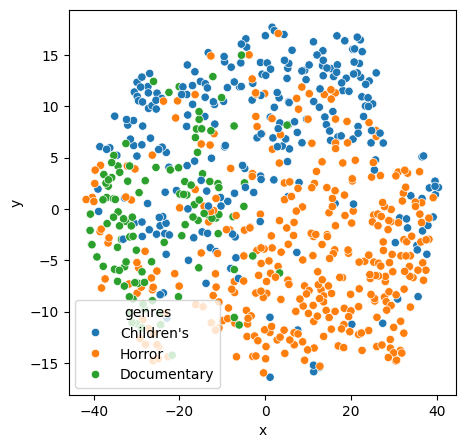

In [ ]:
def single_genre(g):
    for i in ["Children's", "Horror", "Documentary"]:
        if i in g:
            return i


movies_subset["genres"] = movies_subset["genres"].apply(single_genre)
plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x="x", y="y", hue="genres", data=movies_subset)
plt.savefig("movie_emb.png", bbox_inches="tight")

In [ ]:
star_wars_5_index = torch.tensor(6297, device=device)
star_war_embeddings = model.embeddings(star_wars_5_index)
cosine_similarities = torch.tensor(
    [F.cosine_similarity(star_war_embeddings, i, dim=0) for i in movie_embeddings]
)
movies.iloc[cosine_similarities.argsort(descending=True).detach().numpy()][
    "title"
].values[:10]

array(['Star Wars: Episode IV - A New Hope (1977)',
       'Raiders of the Lost Ark (1981)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Shawshank Redemption, The (1994)', 'Ben-Hur (1959)',
       'Saving Private Ryan (1998)', 'Sting, The (1973)',
       'Braveheart (1995)', 'Ghostbusters (1984)'], dtype=object)

In [ ]:
toy_story_index = torch.tensor(6040, device=device)
toy_story_embeddings = model.embeddings(toy_story_index)
cosine_similarities = torch.tensor(
    [F.cosine_similarity(toy_story_embeddings, i, dim=0) for i in movie_embeddings]
)
[
    i
    for i in movies.iloc[cosine_similarities.argsort(descending=True).detach().numpy()][
        "title"
    ].values[:10]
]

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 'Aladdin (1992)',
 'Beauty and the Beast (1991)',
 'Quiet Man, The (1952)',
 "Bug's Life, A (1998)",
 'Lion King, The (1994)',
 'Big (1988)',
 'Persuasion (1995)',
 'Browning Version, The (1994)']

**Recommending**

We can now make movie recommendations to users we have seen in the train data and users we have not seen but know their metadata (like age, gender or occupation). All we have to do is calculate the FM equations once for each movie and see which movies get the highest predicted rating.
For example, if we have a new (never seen in train so no userId embedding) male user (male_index=9754) and his age is between 18 and 25 (age18_25_index=9747) we will calculate $\hat{y}(x)$ for each movie:

$$ \hat{y}(9754, 9747, movie_{i}) := w_{0} + w_{9747} + w_{9754} + w_{movie_{i}} + \sum_{i=\{9747, 9754, movie_{i}\}}\sum_{j} \langle v_{i}, v_{j} \rangle x_{i} x_{j}$$

And choose the moviess with the highest ratings. But the nice thing here is that for recommendation I don’t need the rating itself, it’s enough to rank movies without calculating the full equation. I can do this by ignoring all the terms in $\hat{y}(x)$ that are the same for all movies, and then I’m left with:

$$
score(movie_{i}):= w_{movie_{i}} + \langle v_{movie}, v_{9754} \rangle + \langle v_{movie}, v_{9747} \rangle 
$$

which is the same as 

$$
score(movie_{i}):= w_{movie_{i}} + \langle (v_{9754} + v_{9747}), v_{movie} \rangle 
$$

so, the steps for a new user would be: 
1. Get 'man' embeddings $v_{9754}$.
2. Get 'age 18 to 25' embeddings $v_{9747}$
3. Calculate $v_{metadata} = v_{9754} + v_{9747}$
4. Calculate rank for each movie and return top $10$.

In [ ]:
man_embedding = model.embeddings(torch.tensor(9754, device=device))
age18_25_embedding = model.embeddings(torch.tensor(9747, device=device))
metadata_embedding = man_embedding + age18_25_embedding
rankings = movie_biases.squeeze() + (metadata_embedding * movie_embeddings).sum(1)
[i for i in movies.iloc[rankings.argsort(descending=True).cpu()]["title"].values][:10]

['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'American Beauty (1999)',
 'Godfather, The (1972)',
 'Sanjuro (1962)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Matrix, The (1999)',
 'GoodFellas (1990)']

In [ ]:
woman_embedding = model.embeddings(torch.tensor(9753, device=device))
age50_56_embedding = model.embeddings(torch.tensor(9751, device=device))
metadata_embedding = woman_embedding + age50_56_embedding
rankings = movie_biases.squeeze() + (metadata_embedding * movie_embeddings).sum(1)
[i for i in movies.iloc[rankings.argsort(descending=True).cpu()]["title"].values][:10]

['To Kill a Mockingbird (1962)',
 "Schindler's List (1993)",
 'Wrong Trousers, The (1993)',
 'General, The (1927)',
 'Some Like It Hot (1959)',
 "It's a Wonderful Life (1946)",
 'African Queen, The (1951)',
 'Rocketship X-M (1950)',
 'Grand Day Out, A (1992)',
 "Microcosmos (Microcosmos: Le peuple de l'herbe) (1996)"]

---

## References

1. Rendle, S., Freudenthaler, C., Gantner, Z., & Schmidt-Thieme, L. (2009, June). BPR: Bayesian personalized ranking from implicit feedback. https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf
2. Pan, R., Zhou, Y., Cao, B., Liu, N. N., Lukose, R., Scholz, M., & Yang, Q. (2008, December). One-class collaborative filtering. https://cseweb.ucsd.edu/classes/fa17/cse291-b/reading/04781145.pdf
3. **Cornac** - A Comparative Framework for Multimodal Recommender Systems. https://cornac.preferred.ai/